In [8]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
import seaborn
from scipy.stats import *
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, IndexToString
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [9]:
spark = SparkSession.builder \
.master("local") \
.appName("Exercise3")\
.getOrCreate()

In [10]:
df = spark.read.csv('exampleData.csv', header=True)

In [11]:
df.schema

StructType(List(StructField(_c0,StringType,true),StructField(dateTime,StringType,true),StructField(indicator_rain,StringType,true),StructField(precipitation,StringType,true),StructField(indicator_temp,StringType,true),StructField(air_temperature,StringType,true),StructField(indicator_wetb,StringType,true),StructField(wetb,StringType,true),StructField(dewpt,StringType,true),StructField(vappr,StringType,true),StructField(relative_humidity,StringType,true),StructField(msl,StringType,true),StructField(indicator_wdsp,StringType,true),StructField(wind_speed,StringType,true),StructField(indicator_wddir,StringType,true),StructField(wind_from_direction,StringType,true)))

In [12]:
df.dtypes

[('_c0', 'string'),
 ('dateTime', 'string'),
 ('indicator_rain', 'string'),
 ('precipitation', 'string'),
 ('indicator_temp', 'string'),
 ('air_temperature', 'string'),
 ('indicator_wetb', 'string'),
 ('wetb', 'string'),
 ('dewpt', 'string'),
 ('vappr', 'string'),
 ('relative_humidity', 'string'),
 ('msl', 'string'),
 ('indicator_wdsp', 'string'),
 ('wind_speed', 'string'),
 ('indicator_wddir', 'string'),
 ('wind_from_direction', 'string')]

In [13]:
df.show(1, vertical=True)

-RECORD 0--------------------------------
 _c0                 | 14                
 dateTime            | 01-jan-1990 00:00 
 indicator_rain      | 0                 
 precipitation       | 0.3               
 indicator_temp      | 0                 
 air_temperature     | 9.1               
 indicator_wetb      | 0                 
 wetb                | 9.0               
 dewpt               | 8.9               
 vappr               | 11.4              
 relative_humidity   | 99                
 msl                 | 1006.7            
 indicator_wdsp      | 2                 
 wind_speed          | 7                 
 indicator_wddir     | 2                 
 wind_from_direction | 190               
only showing top 1 row



### String Indexer Example

In [14]:
indexer = StringIndexer(inputCol="dateTime" ,outputCol="indexedTime")

In [15]:
indexed = indexer.fit(df).transform(df) # return a df

In [16]:
indexed.show(2, vertical=True) 

-RECORD 0--------------------------------
 _c0                 | 14                
 dateTime            | 01-jan-1990 00:00 
 indicator_rain      | 0                 
 precipitation       | 0.3               
 indicator_temp      | 0                 
 air_temperature     | 9.1               
 indicator_wetb      | 0                 
 wetb                | 9.0               
 dewpt               | 8.9               
 vappr               | 11.4              
 relative_humidity   | 99                
 msl                 | 1006.7            
 indicator_wdsp      | 2                 
 wind_speed          | 7                 
 indicator_wddir     | 2                 
 wind_from_direction | 190               
 indexedTime         | 2667.0            
-RECORD 1--------------------------------
 _c0                 | 15                
 dateTime            | 01-jan-1990 01:00 
 indicator_rain      | 0                 
 precipitation       | 0.2               
 indicator_temp      | 0          

In [17]:
indexed.dtypes

[('_c0', 'string'),
 ('dateTime', 'string'),
 ('indicator_rain', 'string'),
 ('precipitation', 'string'),
 ('indicator_temp', 'string'),
 ('air_temperature', 'string'),
 ('indicator_wetb', 'string'),
 ('wetb', 'string'),
 ('dewpt', 'string'),
 ('vappr', 'string'),
 ('relative_humidity', 'string'),
 ('msl', 'string'),
 ('indicator_wdsp', 'string'),
 ('wind_speed', 'string'),
 ('indicator_wddir', 'string'),
 ('wind_from_direction', 'string'),
 ('indexedTime', 'double')]

### Task - Predict air_temp from date, humidity, wind speed and msl

In [18]:
# Parse data type
parsed_df = indexed.selectExpr("cast(dateTime as string) dateTime", 
                          "cast(relative_humidity as float) relative_humidity",
                          "cast(wind_speed as float) wind_speed",
                          "cast(indexedTime as double) indexedTime",
                          "cast(msl as float) msl",
                          "cast(air_temperature as float) label") # df after parsed

In [19]:
# Put all discreted data/features into 1D vector (as 1 column in the df)
vectorAssembler = VectorAssembler(inputCols = ['relative_humidity', 'wind_speed', 'indexedTime', 'msl'], handleInvalid="skip",outputCol ='features')

In [20]:
vectorized_df = vectorAssembler.transform(parsed_df)

In [21]:
vectorized_df.show(1)

+-----------------+-----------------+----------+-----------+------+-----+--------------------+
|         dateTime|relative_humidity|wind_speed|indexedTime|   msl|label|            features|
+-----------------+-----------------+----------+-----------+------+-----+--------------------+
|01-jan-1990 00:00|             99.0|       7.0|     2667.0|1006.7|  9.1|[99.0,7.0,2667.0,...|
+-----------------+-----------------+----------+-----------+------+-----+--------------------+
only showing top 1 row



In [22]:
dataset = vectorized_df.select("features", "label") # remove unnecessary cols

In [23]:
dataset.show(1)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[99.0,7.0,2667.0,...|  9.1|
+--------------------+-----+
only showing top 1 row



### Model - Gradient-Boosted Trees

In [24]:
# Split data
(trainData, testData) = dataset.randomSplit([0.8, 0.2])

In [25]:
print("Train sample: {}".format(trainData.count()))
print("Test sample: {}".format(testData.count()))

Train sample: 151492
Test sample: 37656


In [26]:
testData.show(1)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.0,235855.0...| 20.4|
+--------------------+-----+
only showing top 1 row



In [27]:
#### NORMAL 

In [28]:
gbt = GBTRegressor(featuresCol="features", maxIter=30, maxDepth = 11)
s = time.time()
model_direct = gbt.fit(trainData)
print(time.time() - s)

182.0609052181244


In [29]:
pred_direct = model_direct.transform(testData)

In [30]:
pred_direct.show(5)

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[0.0,0.0,235855.0...| 20.4|16.521116061538837|
|[0.0,0.0,235858.0...| 18.5|16.232728165661076|
|[0.0,0.0,235862.0...| 13.9|14.792901987882253|
|[0.0,1.0,167217.0...|  7.0| 8.345977078478935|
|[0.0,1.0,180642.0...| 15.2|15.461789921821767|
+--------------------+-----+------------------+
only showing top 5 rows



In [31]:
#### WITH PIPELINE

In [32]:
# Transform step - Index features (if needed)
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", handleInvalid="skip").fit(dataset)

# Transform step - Index labels (if needed)
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(dataset)

# Transform step - Indexed to orginal (if the labels are indexed)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",labels=labelIndexer.labels)

In [33]:
gbt = GBTRegressor(featuresCol="indexedFeatures", maxIter=30, maxDepth = 11)

In [34]:
# No idea what the param meaning?
# gbt.explainParam("maxIter") # explain specific param
# gbt.explainParams() # explain all params

In [35]:
pipeline = Pipeline(stages=[featureIndexer, gbt])
# pipeline = Pipeline(stages=[featureIndexer, labelIndexer, gbt])
# pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt, labelConverter])

In [36]:
s = time.time()
model_gbt = pipeline.fit(trainData)
print(time.time() - s)

176.48414397239685


In [37]:
pred = model_gbt.transform(testData) # return a df

In [38]:
pred.show(5)

+--------------------+-----+--------------------+------------------+
|            features|label|     indexedFeatures|        prediction|
+--------------------+-----+--------------------+------------------+
|[0.0,0.0,235855.0...| 20.4|[0.0,0.0,235855.0...|16.521116061538837|
|[0.0,0.0,235858.0...| 18.5|[0.0,0.0,235858.0...|16.232728165661076|
|[0.0,0.0,235862.0...| 13.9|[0.0,0.0,235862.0...|14.792901987882253|
|[0.0,1.0,167217.0...|  7.0|[0.0,1.0,167217.0...| 8.345977078478935|
|[0.0,1.0,180642.0...| 15.2|[0.0,1.0,180642.0...|15.461789921821767|
+--------------------+-----+--------------------+------------------+
only showing top 5 rows



### Model - Random Forest

In [39]:
rforest = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=40, maxDepth=7)

In [40]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rforest, labelConverter])

In [41]:
s = time.time()
model_forest = pipeline.fit(trainData)
print(time.time() - s)

28.316558599472046


In [42]:
pred_forest = model_forest.transform(testData).select("features", "label", "predictedLabel")

In [43]:
pred_forest.show(10)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|[0.0,0.0,235855.0...| 20.4|          15.6|
|[0.0,0.0,235858.0...| 18.5|          15.6|
|[0.0,0.0,235862.0...| 13.9|          15.6|
|[0.0,1.0,167217.0...|  7.0|           4.0|
|[0.0,1.0,180642.0...| 15.2|          15.6|
|[0.0,1.0,233159.0...| 12.5|          15.6|
|[0.0,2.0,180647.0...| 16.0|          15.6|
|[0.0,2.0,224943.0...| 11.4|          15.6|
|[0.0,2.0,238548.0...|  8.6|          16.6|
|[0.0,3.0,6810.0,1...| 16.2|          15.6|
+--------------------+-----+--------------+
only showing top 10 rows



### Evaluation metrics

In [44]:
rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse") # root mean square err

In [45]:
rmse_result = rmse.evaluate(pred)

In [46]:
rmse_result

3.575537980595232

In [47]:
rsquare = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2") # r-squared

In [48]:
rsquare_result = rsquare.evaluate(pred)

In [49]:
rsquare_result

0.23082695069764902

In [50]:
mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae") # mean absolute err

In [51]:
mae_result = mae.evaluate(pred)

In [52]:
mae_result

2.805661110162392

### Plotting

In [53]:
pred_pd = pred.toPandas()

In [54]:
seaborn.set(style="whitegrid", font_scale = 1.9)

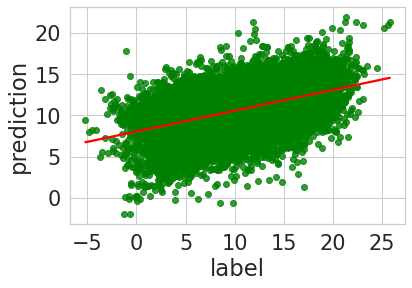

In [55]:
# Using Seaborn
fig, ax = plt.subplots()
seaborn.set(color_codes=True)
seaborn.set(rc={'figure.figsize':(15, 10)})
seaborn.regplot(x="label", y="prediction", fit_reg=False, ax=ax,data= pred_pd,scatter_kws={"color": "green"});
seaborn.regplot(x="label", y="prediction",scatter=False, ax=ax, data= pred_pd, line_kws={"color": "red"});

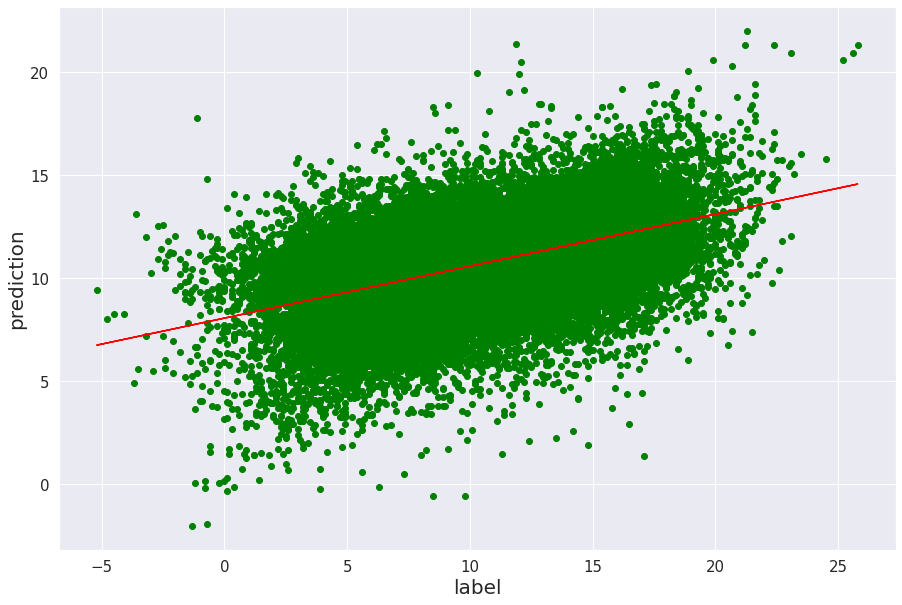

In [56]:
# Using matplotlib
fig_, ax_ = plt.subplots(figsize=(15, 10))
ax_.scatter(pred_pd.label, pred_pd.prediction, color='green', marker='o')
# Line plot (regression line)
m, b = np.polyfit(pred_pd.label, pred_pd.prediction, 1) # compute linear regression
ax_.plot(pred_pd.label, m*pred_pd.label + b, color='red')
ax_.set_xlabel('label', fontsize=20)
ax_.set_ylabel('prediction', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()